In [1]:
from pyspark import SparkConf
from pyspark.sql import SparkSession

dudas 

capas silver carpeta link 

spark local 

medidas intermedias 

diferencia entre over write en silver desde bronce (tema rendimiento)
write parquet 
pandas no escala, trabaja en memoria de un pc 
cluster cada nodo 128 gb, 4 nodo 

window de spark 

In [2]:
conf = (SparkConf()
            .setMaster("yarn")
            .set("spark.executor.cores", 5)
            .set("spark.sql.shuffle.partitions", 200)
            .set("spark.default.parallelism", 200)
            .set("spark.executor.memory", "7g")
            .set("spark.dynamicAllocation.maxExecutors", 20)
        )

spark = SparkSession \
    .builder \
    .config(conf=conf) \
    .appName("Test_PySpark") \
    .getOrCreate()

#No tocar!!! 

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [3]:
# Ejemplo de creación de un DataFrame a partir de los datos almacenados en HDFS
df_bronce = spark.read \
          .option("header","true") \
          .option("inferSchema", "true") \
          .csv("/datos/gittba26/gittba10/bronce/LINK")

In [4]:
df_bronce.printSchema()

root
 |-- date: date (nullable = true)
 |-- open: double (nullable = true)
 |-- high: double (nullable = true)
 |-- low: double (nullable = true)
 |-- close: double (nullable = true)
 |-- volume: double (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)



In [5]:
df_bronce.show()

[Stage 3:>                                                          (0 + 1) / 1]

+----------+----------+----------+----------+----------+------------------+----+-----+
|      date|      open|      high|       low|     close|            volume|year|month|
+----------+----------+----------+----------+----------+------------------+----+-----+
|2024-05-01|13.1412687|13.5671928|12.3938758|13.3468614| 319604.4699999998|2024|    5|
|2024-05-02|13.3408292|13.8018963| 12.934852|13.6040873|137790.47000000038|2024|    5|
|2024-05-03|13.5992045|14.2089571| 13.470351|14.0974049|181321.24999999997|2024|    5|
|2024-05-04|14.1013886|14.4886998| 13.987964| 14.319916|151191.83000000002|2024|    5|
|2024-05-05|14.3399506|14.6649421|14.1161335|14.3834613| 98370.21000000015|2024|    5|
|2024-05-06|14.3874776|15.1696417|14.2994557|14.4952974|203470.25000000026|2024|    5|
|2024-05-07|14.4939256|14.7204727|13.9697015|14.0035158|181185.62000000017|2024|    5|
|2024-05-08|14.0094497|14.1144736|13.6977612|13.9008841|166258.99000000022|2024|    5|
|2024-05-09|13.8955722|14.3825288|13.842560

In [6]:
df_bronce.count()

1500

In [7]:
#Asegurar tipos y orden
from pyspark.sql.functions import col, to_date

df_silver = df_bronce.withColumn(
    "date", to_date(col("date"))
)


In [8]:
#Escribir SILVER en Parquet (deberiamos verlo en HDFS) 
df_silver.write \
    .mode("overwrite") \
    .partitionBy("year", "month") \
    .parquet("hdfs:///datos/gittba26/gittba10/silver/LINK")


In [9]:
df_silver

DataFrame[date: date, open: double, high: double, low: double, close: double, volume: double, year: int, month: int]

In [6]:
df = spark.read.parquet(
    "hdfs:///datos/gittba26/gittba10/silver/LINK"
).orderBy("date")


In [7]:
df

DataFrame[date: date, open: double, high: double, low: double, close: double, volume: double, year: int, month: int]

In [8]:
df.show()

[Stage 5:=======================>                                 (21 + 5) / 50]

+----------+----------+----------+----------+----------+------------------+----+-----+
|      date|      open|      high|       low|     close|            volume|year|month|
+----------+----------+----------+----------+----------+------------------+----+-----+
|2021-12-19|19.5407785|20.4753136| 18.684929|18.8858893|1301433.3186120107|2021|   12|
|2021-12-20|18.8314516|19.3364643|18.0459231|18.7826604|1061706.6733017915|2021|   12|
|2021-12-21|18.7843697| 19.783351|18.1942312|19.4423482|   870560.12910522|2021|   12|
|2021-12-22|19.4361623|20.9800513|19.1426915|19.9265291|  1307950.53809432|2021|   12|
|2021-12-23|19.8775594|22.7751495|19.5119801|22.1751089|1190757.9329622407|2021|   12|
|2021-12-24|22.1609142|22.9233984|21.1990588|21.4729912|   873919.15611457|2021|   12|
|2021-12-25|21.4928613|22.5026089|21.1218369|22.1180891| 618488.3123398793|2021|   12|
|2021-12-26| 22.116769|24.0559452|21.0318718|22.9877693|1202119.5181933888|2021|   12|
|2021-12-27|23.0184937|24.7231724|22.750894

## Cálculo de Indicadores Técnicos (KPIs)

### 1. SMA 200 (Simple Moving Average)

La SMA 200 es la media aritmética del precio de cierre (`close`) de los últimos 200 periodos. Se calcula sumando los valores de `close` de los 200 días anteriores (incluyendo el actual) y dividiendo entre 200. En Spark se implementa mediante una función de ventana ordenada por fecha, utilizando `rowsBetween(-199, 0)` y aplicando la función `avg(close)` sobre esa ventana. Este indicador no requiere variables intermedias adicionales, únicamente el precio de cierre y la definición correcta de la ventana temporal.


### 2. EMA 50 (Exponential Moving Average)

La EMA 50 es una media móvil exponencial que da mayor peso a los valores más recientes. Se basa en un factor de suavizado α definido como:

α = 2 / (n + 1), donde n = 50.

La fórmula es:

EMA_t = Close_t * α + EMA_{t-1} * (1 - α)

En Spark, dado que no existe una función recursiva nativa para la EMA, se implementa utilizando el valor actual de `close`, el valor anterior mediante `lag(close)`, y el factor α. Las medidas internas necesarias son el cálculo de α y el uso de `lag(close)` dentro de una ventana ordenada por fecha.


### 3. RSI (Relative Strength Index)

El RSI mide la fuerza del movimiento del precio comparando ganancias y pérdidas medias en un periodo (normalmente 14 días). Su cálculo requiere varios pasos intermedios:

1. diff = close_t - close_{t-1}
2. gain = diff si diff > 0, en caso contrario 0
3. loss = valor absoluto de diff si diff < 0, en caso contrario 0
4. avg_gain = media móvil de gain en una ventana de 14 días
5. avg_loss = media móvil de loss en una ventana de 14 días

Posteriormente se calcula:

RS = avg_gain / avg_loss

RSI = 100 - (100 / (1 + RS))

Para evitar divisiones por cero, cuando avg_loss es 0 se asigna un valor de RSI = 100. Las variables intermedias (diff, gain, loss, avg_gain, avg_loss) se utilizan únicamente para el cálculo y se eliminan en la capa Gold final.


### 4. MACD (Moving Average Convergence Divergence)

El MACD se calcula como la diferencia entre dos medias móviles exponenciales de distinto periodo:

MACD = EMA_12 - EMA_26

Para ello se calculan previamente:

α_12 = 2 / (12 + 1)
α_26 = 2 / (26 + 1)

Se generan dos medidas internas (EMA_12 y EMA_26) utilizando la misma lógica que en la EMA 50. Una vez calculadas, el MACD se obtiene restando ambas. Las columnas intermedias pueden eliminarse posteriormente en la capa Gold.


In [14]:
from pyspark.sql.window import Window
from pyspark.sql.functions import avg

window_sma_200 = Window.orderBy("date").rowsBetween(-199, 0)

df_1 = df.withColumn(
    "SMA_200",
    avg(col("close")).over(window_sma_200)
)


In [15]:
df_1

DataFrame[date: date, open: double, high: double, low: double, close: double, volume: double, year: int, month: int, SMA_200: double]

In [16]:
df_1.show()

[Stage 16:>                                                         (0 + 1) / 1]

+----------+----------+----------+----------+----------+------------------+----+-----+------------------+
|      date|      open|      high|       low|     close|            volume|year|month|           SMA_200|
+----------+----------+----------+----------+----------+------------------+----+-----+------------------+
|2021-12-19|19.5407785|20.4753136| 18.684929|18.8858893|1301433.3186120107|2021|   12|        18.8858893|
|2021-12-20|18.8314516|19.3364643|18.0459231|18.7826604|1061706.6733017915|2021|   12|       18.83427485|
|2021-12-21|18.7843697| 19.783351|18.1942312|19.4423482|   870560.12910522|2021|   12|19.036965966666667|
|2021-12-22|19.4361623|20.9800513|19.1426915|19.9265291|  1307950.53809432|2021|   12|       19.25935675|
|2021-12-23|19.8775594|22.7751495|19.5119801|22.1751089|1190757.9329622407|2021|   12|       19.84250718|
|2021-12-24|22.1609142|22.9233984|21.1990588|21.4729912|   873919.15611457|2021|   12|20.114254516666666|
|2021-12-25|21.4928613|22.5026089|21.1218369|2

In [18]:
from pyspark.sql.functions import lag

alpha = 2 / (50 + 1)
window_ema = Window.orderBy("date")

df_2 = df_1.withColumn(
    "EMA_50",
    col("close") * alpha +
    lag(col("close"), 1).over(window_ema) * (1 - alpha)
)


In [19]:
df_2

DataFrame[date: date, open: double, high: double, low: double, close: double, volume: double, year: int, month: int, SMA_200: double, EMA_50: double]

In [20]:
df_2.show()

[Stage 23:>                                                         (0 + 1) / 1]

+----------+----------+----------+----------+----------+------------------+----+-----+------------------+------------------+
|      date|      open|      high|       low|     close|            volume|year|month|           SMA_200|            EMA_50|
+----------+----------+----------+----------+----------+------------------+----+-----+------------------+------------------+
|2021-12-19|19.5407785|20.4753136| 18.684929|18.8858893|1301433.3186120107|2021|   12|        18.8858893|              NULL|
|2021-12-20|18.8314516|19.3364643|18.0459231|18.7826604|1061706.6733017915|2021|   12|       18.83427485|18.881841107843137|
|2021-12-21|18.7843697| 19.783351|18.1942312|19.4423482|   870560.12910522|2021|   12|19.036965966666667|18.808530509803923|
|2021-12-22|19.4361623|20.9800513|19.1426915|19.9265291|  1307950.53809432|2021|   12|       19.25935675|19.461335686274513|
|2021-12-23|19.8775594|22.7751495|19.5119801|22.1751089|1190757.9329622407|2021|   12|       19.84250718|        20.0147087|


In [21]:
df= df_2

In [22]:
from pyspark.sql.functions import when

df = df.withColumn(
    "diff",
    col("close") - lag(col("close"), 1).over(window_ema)
)

df = df.withColumn(
    "gain", when(col("diff") > 0, col("diff")).otherwise(0)
).withColumn(
    "loss", when(col("diff") < 0, -col("diff")).otherwise(0)
)

window_rsi = Window.orderBy("date").rowsBetween(-13, 0)

df = df.withColumn(
    "avg_gain", avg(col("gain")).over(window_rsi)
).withColumn(
    "avg_loss", avg(col("loss")).over(window_rsi)
)

df = df.withColumn(
    "RSI",
    when(col("avg_loss") == 0, 100)
    .otherwise(100 - (100 / (1 + col("avg_gain") / col("avg_loss"))))
)


In [23]:
df

DataFrame[date: date, open: double, high: double, low: double, close: double, volume: double, year: int, month: int, SMA_200: double, EMA_50: double, diff: double, gain: double, loss: double, avg_gain: double, avg_loss: double, RSI: double]

In [24]:
df.show()

[Stage 30:>                                                         (0 + 1) / 1]

+----------+----------+----------+----------+----------+------------------+----+-----+------------------+------------------+--------------------+-------------------+-------------------+-------------------+--------------------+------------------+
|      date|      open|      high|       low|     close|            volume|year|month|           SMA_200|            EMA_50|                diff|               gain|               loss|           avg_gain|            avg_loss|               RSI|
+----------+----------+----------+----------+----------+------------------+----+-----+------------------+------------------+--------------------+-------------------+-------------------+-------------------+--------------------+------------------+
|2021-12-19|19.5407785|20.4753136| 18.684929|18.8858893|1301433.3186120107|2021|   12|        18.8858893|              NULL|                NULL|                0.0|                0.0|                0.0|                 0.0|             100.0|
|2021-12-20|18.8

In [25]:
alpha_12 = 2 / (12 + 1)
alpha_26 = 2 / (26 + 1)

df = df.withColumn(
    "EMA_12",
    col("close") * alpha_12 +
    lag(col("close"), 1).over(window_ema) * (1 - alpha_12)
).withColumn(
    "EMA_26",
    col("close") * alpha_26 +
    lag(col("close"), 1).over(window_ema) * (1 - alpha_26)
)

df = df.withColumn(
    "MACD",
    col("EMA_12") - col("EMA_26")
)


In [27]:
gold_df = df.select(
    "date",
    "open",
    "high",
    "low",
    "close",
    "volume",
    "year",
    "month",
    "SMA_200",
    "EMA_50",
    "RSI",
    "MACD"
)


In [28]:
gold_df

DataFrame[date: date, open: double, high: double, low: double, close: double, volume: double, year: int, month: int, SMA_200: double, EMA_50: double, RSI: double, MACD: double]

In [29]:
gold_df.show()

[Stage 37:>                                                         (0 + 1) / 1]

+----------+----------+----------+----------+----------+------------------+----+-----+------------------+------------------+------------------+--------------------+
|      date|      open|      high|       low|     close|            volume|year|month|           SMA_200|            EMA_50|               RSI|                MACD|
+----------+----------+----------+----------+----------+------------------+----+-----+------------------+------------------+------------------+--------------------+
|2021-12-19|19.5407785|20.4753136| 18.684929|18.8858893|1301433.3186120107|2021|   12|        18.8858893|              NULL|             100.0|                NULL|
|2021-12-20|18.8314516|19.3364643|18.0459231|18.7826604|1061706.6733017915|2021|   12|       18.83427485|18.881841107843137|               0.0|-0.00823478404558...|
|2021-12-21|18.7843697| 19.783351|18.1942312|19.4423482|   870560.12910522|2021|   12|19.036965966666667|18.808530509803923| 86.46917808982317|0.052624667806266956|
|2021-12-2

In [31]:
gold_df.write \
    .mode("overwrite") \
    .partitionBy("year", "month") \
    .parquet("hdfs:///datos/gittba26/gittba10/gold/LINK")


In [33]:
spark.read.parquet(
    "hdfs:///datos/gittba26/gittba10/gold"
).select("date", "RSI", "MACD").show(10)


+----------+------------------+--------------------+
|      date|               RSI|                MACD|
+----------+------------------+--------------------+
|2022-07-01| 46.20221925546003| -0.0168413299145298|
|2022-07-02| 54.26276959519275|0.011990645014245516|
|2022-07-03|43.211093514314975|-5.59170370370232...|
|2022-07-04|39.719092940645474| 0.01722185071225102|
|2022-07-05| 39.83487167746707|-0.00936314415954...|
|2022-07-06| 44.09680436163095|0.001652709971510...|
|2022-07-07|42.701511318436786|0.024744740740739957|
|2022-07-08|31.178379903508798|-0.02283821994302...|
|2022-07-09| 34.72626381754327|0.010335860968661237|
|2022-07-10| 38.92292479635625|-0.02318766951566964|
+----------+------------------+--------------------+
only showing top 10 rows



In [9]:
df_gold = spark.read.parquet(
    "hdfs:///datos/gittba26/gittba10/gold/LINK"
).orderBy("date")

In [11]:
df_gold.show()

[Stage 7:>                                                         (0 + 5) / 50]

+----------+----------+----------+----------+----------+------------------+------------------+------------------+------------------+--------------------+----+-----+
|      date|      open|      high|       low|     close|            volume|           SMA_200|            EMA_50|               RSI|                MACD|year|month|
+----------+----------+----------+----------+----------+------------------+------------------+------------------+------------------+--------------------+----+-----+
|2021-12-19|19.5407785|20.4753136| 18.684929|18.8858893|1301433.3186120107|        18.8858893|              NULL|             100.0|                NULL|2021|   12|
|2021-12-20|18.8314516|19.3364643|18.0459231|18.7826604|1061706.6733017915|       18.83427485|18.881841107843137|               0.0|-0.00823478404558...|2021|   12|
|2021-12-21|18.7843697| 19.783351|18.1942312|19.4423482|   870560.12910522|19.036965966666667|18.808530509803923| 86.46917808982317|0.052624667806266956|2021|   12|
|2021-12-2

In [12]:
pdf = df_gold.orderBy("date").limit(300).toPandas()


In [13]:
pdf.head()


,date,open,high,low,close,volume,SMA_200,EMA_50,RSI,MACD,year,month
0,2021-12-19,19.540778,20.475314,18.684929,18.885889,1.301433e+06,18.885889,NaN,100.000000,NaN,2021,12
1,2021-12-20,18.831452,19.336464,18.045923,18.782660,1.061707e+06,18.834275,18.881841,0.000000,-0.008235,2021,12
2,2021-12-21,18.784370,19.783351,18.194231,19.442348,8.705601e+05,19.036966,18.808531,86.469178,0.052625,2021,12
3,2021-12-22,19.436162,20.980051,19.142692,19.926529,1.307951e+06,19.259357,19.461336,91.722468,0.038624,2021,12
4,2021-12-23,19.877559,22.775150,19.511980,22.175109,1.190758e+06,19.842507,20.014709,97.046956,0.179374,2021,12


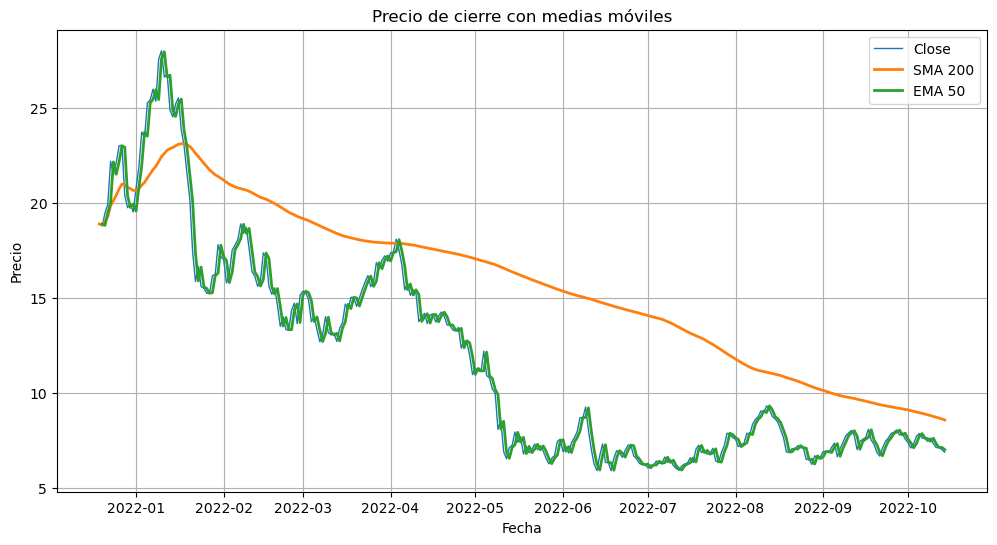

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(pdf["date"], pdf["close"], label="Close", linewidth=1)
plt.plot(pdf["date"], pdf["SMA_200"], label="SMA 200", linewidth=2)
plt.plot(pdf["date"], pdf["EMA_50"], label="EMA 50", linewidth=2)

plt.title("Precio de cierre con medias móviles")
plt.xlabel("Fecha")
plt.ylabel("Precio")
plt.legend()
plt.grid(True)
plt.show()


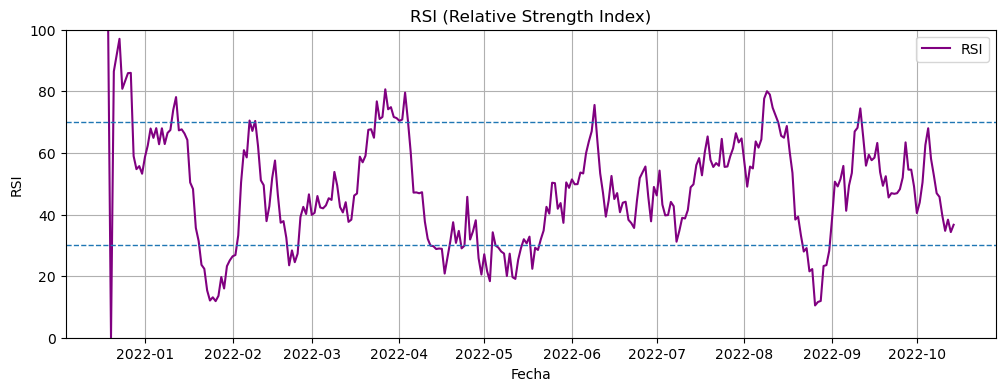

In [15]:
plt.figure(figsize=(12,4))
plt.plot(pdf["date"], pdf["RSI"], label="RSI", color="purple")

plt.axhline(70, linestyle="--", linewidth=1)
plt.axhline(30, linestyle="--", linewidth=1)

plt.title("RSI (Relative Strength Index)")
plt.xlabel("Fecha")
plt.ylabel("RSI")
plt.ylim(0,100)
plt.legend()
plt.grid(True)
plt.show()


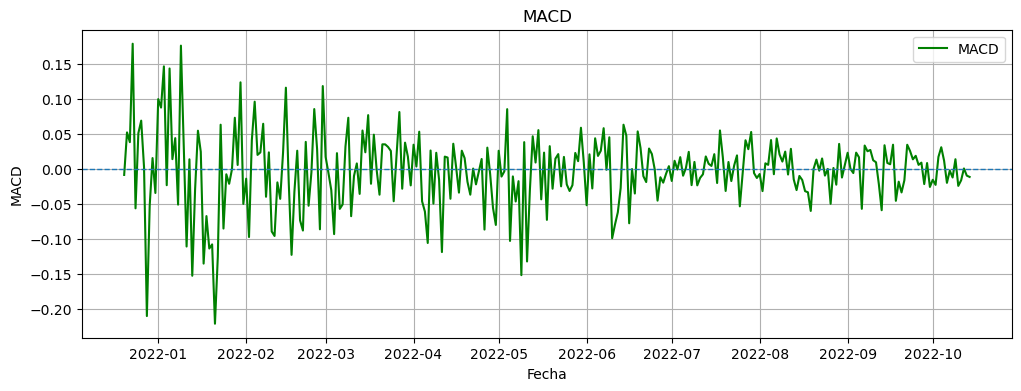

In [16]:
plt.figure(figsize=(12,4))
plt.plot(pdf["date"], pdf["MACD"], label="MACD", color="green")

plt.axhline(0, linestyle="--", linewidth=1)

plt.title("MACD")
plt.xlabel("Fecha")
plt.ylabel("MACD")
plt.legend()
plt.grid(True)
plt.show()


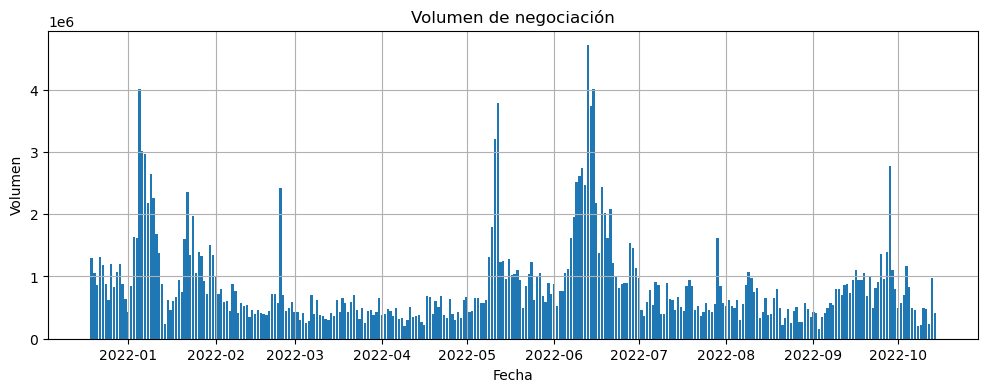

In [17]:
plt.figure(figsize=(12,4))
plt.bar(pdf["date"], pdf["volume"])

plt.title("Volumen de negociación")
plt.xlabel("Fecha")
plt.ylabel("Volumen")
plt.grid(True)
plt.show()


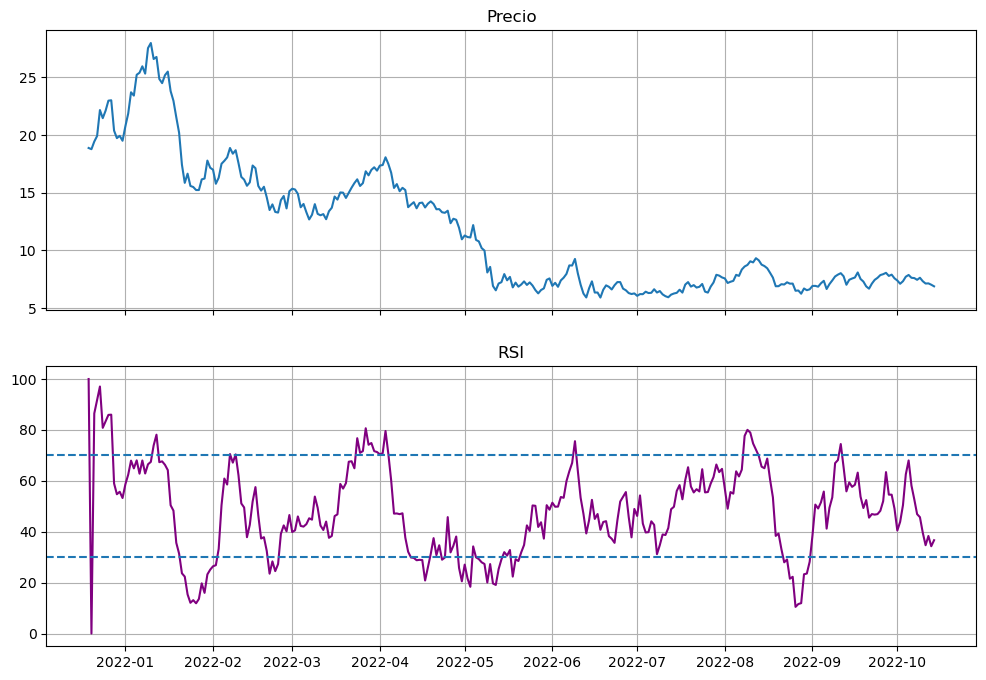

In [18]:
fig, ax = plt.subplots(2, 1, figsize=(12,8), sharex=True)

ax[0].plot(pdf["date"], pdf["close"], label="Close")
ax[0].set_title("Precio")
ax[0].grid(True)

ax[1].plot(pdf["date"], pdf["RSI"], color="purple")
ax[1].axhline(70, linestyle="--")
ax[1].axhline(30, linestyle="--")
ax[1].set_title("RSI")
ax[1].grid(True)

plt.show()


In [28]:
pdf_prueba = df_gold.orderBy("date").limit(200).toPandas()


In [29]:
import pandas as pd

In [30]:
pdf_prueba["date"] = pd.to_datetime(pdf_prueba["date"])


In [31]:
pdf_prueba = pdf_prueba.reset_index(drop=True)


AttributeError: Can only use .dt accessor with datetimelike values

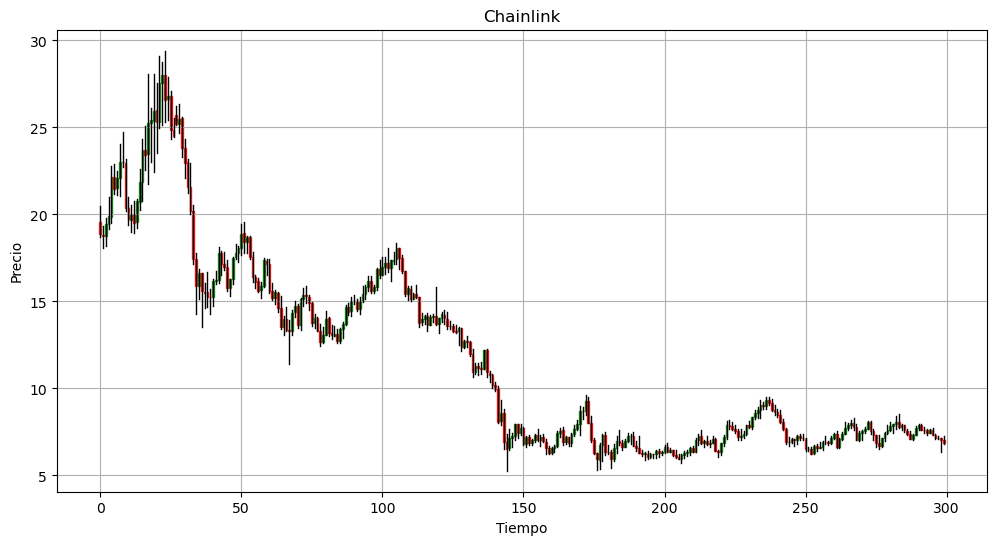

In [33]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

plt.figure(figsize=(12,6))

for i in range(len(pdf)):
    open_price = pdf.loc[i, "open"]
    close_price = pdf.loc[i, "close"]
    high = pdf.loc[i, "high"]
    low = pdf.loc[i, "low"]

    color = "green" if close_price >= open_price else "red"

    # Mecha (high-low)
    plt.plot([i, i], [low, high], color="black", linewidth=1)

    # Cuerpo de la vela
    rect = Rectangle(
        (i - 0.3, min(open_price, close_price)),
        0.6,
        abs(close_price - open_price),
        color=color,
        alpha=0.8
    )
    plt.gca().add_patch(rect)

plt.title("Chainlink")
plt.xlabel("Tiempo")
plt.ylabel("Precio")
plt.grid(True)

# Reducimos número de fechas en el eje X
plt.xticks(
    ticks=range(0, len(pdf), 20),
    labels=pdf["date"].dt.strftime("%Y-%m-%d")[::20],
    rotation=45
)

plt.tight_layout()
plt.show()


dudas: parquet porque no se pueden ver los datos 

codigo: lo subimos a git hub?? 